In [56]:
%load_ext autoreload
%autoreload 2


from util_0701 import *
# from myalgorithm_0701_1 import algorithm

import pandas as pd

import pickle

import matplotlib as mpl
from matplotlib import pyplot
import numpy as np
import seaborn as sns

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


- 실험해볼 내용들

1. 4번들 묶을 때 2까지, 4까지 (2 또는 3은 X), 3까지로 변경 -> 4번들 묶을 때 번들 수 lower limit을 주어 실험한 결과 2 -> 4 -> 3 순서로 4번들 묶을 때 4번들만 만드는 것은 오히려 비용이 높았음
2. weight1과 weight2의 적정선은 어느 정도일까?

- 코드 구조 개선

1. kruskal_bundling 함수로 크루스칼을 이용해서 번들링하는 기능을 get_init_bundle류 함수에서 분리하기 -> 완료

In [6]:
problem_file = '../alg_test_problems_20240429/TEST_K100_1.json'
# problem_file = '../alg_test_problems_20240429/TEST_K100_2.json'
# problem_file = r'C:\Users\hsh80\Desktop\LG CNS\stage1_problems\STAGE1_18.json'

## 적정 weight 탐색 실험

In [7]:
## ------------------- 초기 상태 할당 코드 -------------------------

with open(problem_file, 'r') as f:
    prob = json.load(f)

K = prob['K']

ALL_ORDERS = [Order(order_info) for order_info in prob['ORDERS']]
ALL_RIDERS = [Rider(rider_info) for rider_info in prob['RIDERS']]

DIST = np.array(prob['DIST'])
for r in ALL_RIDERS:
    r.T = np.round(DIST/r.speed + r.service_time).astype(int)

## --------------- 초기 번들링 최적화 코드 --------------------------

inf = float('inf')

car_rider = [rider for rider in ALL_RIDERS if rider.type == 'CAR'][0]
bike_rider = [rider for rider in ALL_RIDERS if rider.type == 'BIKE'][0]
walk_rider = [rider for rider in ALL_RIDERS if rider.type == 'WALK'][0]

init_availables = [rider.available_number for rider in ALL_RIDERS]

min_init_cost = inf
min_init_cost_bundle = []
min_init_cost_rider_availables = []

# try_merging_bundles_by_dist // 모든 배달원과 모든 조합에서의 최소 거리를 보는 케이스
# try_merging_bundles_by_dist_walk_prefered // 위와 동일하지만 우선적으로 도보 배달원을 할당하는 케이스
# try_merging_bundles_by_cost // 번들 합칠 때 거리가 아닌 비용을 보는 케이스

weight_experiment_data = []
grid = [-3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 2.5, 3]
for weight1 in grid:
    for weight2 in grid:
        bundles, result_rider_availables, cost = get_init_bundle_4_order_bundle_prefered(K, ALL_RIDERS, ALL_ORDERS, DIST, init_availables, weight1, weight2)
        weight_experiment_data.append((weight1, weight2, cost))


In [54]:
test_case_name = 'TEST_K100_1'
initializer_name = 'get_init_bundle_4_order_bundle_prefered'

### 가중치 저장

In [61]:
with open(f'alg_test_0701_cost_by_weights/{test_case_name}-{initializer_name}.pickle', 'wb') as file:
    pickle.dump(weight_experiment_data, file)

### 가중치 불러오기

In [59]:
ws = ''
with open(f'alg_test_0701_cost_by_weights/{test_case_name}-{initializer_name}.pickle', 'rb') as file:
    ws = pickle.load(file)

### 가중치 조합별 비용 시각화

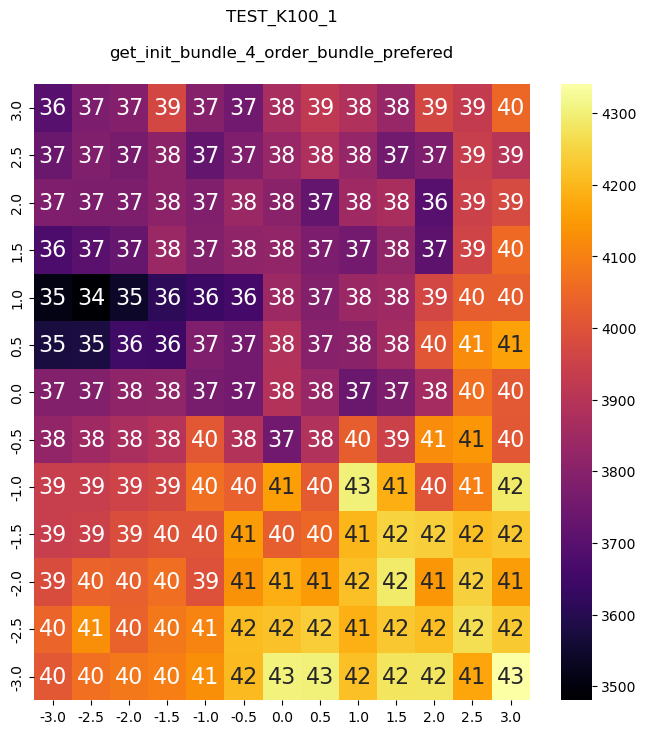

In [52]:
weight_experiment_data.sort()

weight_experiment_data2 = []
labels = []
temp_labels = []
temp_data = []
for _, _, v in weight_experiment_data:
    temp_data.append(v)
    temp_labels.append(str(int(v // 100)))

    if len(temp_labels) == len(grid):
        weight_experiment_data2.append(temp_data)
        labels.append(temp_labels)

        temp_data = []
        temp_labels = []

weight_experiment_data2.reverse()
labels.reverse()

data_df = pd.DataFrame(data=weight_experiment_data2, columns=grid, index=reversed(grid))
plt.figure(figsize=(8, 8))

plt.title(f'{test_case_name}\n\n{initializer_name}\n')

ax = sns.heatmap(data_df, cmap="inferno", annot=labels, annot_kws={'fontsize': 16}, fmt='s')
plt.show()

## kruskal_bundling 함수로 크루스칼을 이용해서 번들링하는 기능을 get_init_bundle류 함수에서 분리하기

In [35]:
## ------------------- 초기 상태 할당 코드 -------------------------

with open(problem_file, 'r') as f:
    prob = json.load(f)

K = prob['K']

ALL_ORDERS = [Order(order_info) for order_info in prob['ORDERS']]
ALL_RIDERS = [Rider(rider_info) for rider_info in prob['RIDERS']]

DIST = np.array(prob['DIST'])
for r in ALL_RIDERS:
    r.T = np.round(DIST/r.speed + r.service_time).astype(int)

## --------------- 초기 번들링 최적화 코드 --------------------------

inf = float('inf')

car_rider = [rider for rider in ALL_RIDERS if rider.type == 'CAR'][0]
bike_rider = [rider for rider in ALL_RIDERS if rider.type == 'BIKE'][0]
walk_rider = [rider for rider in ALL_RIDERS if rider.type == 'WALK'][0]

init_availables = [rider.available_number for rider in ALL_RIDERS]

min_init_cost = inf
min_init_cost_bundle = []
min_init_cost_rider_availables = []

# try_merging_bundles_by_dist // 모든 배달원과 모든 조합에서의 최소 거리를 보는 케이스
# try_merging_bundles_by_dist_walk_prefered // 위와 동일하지만 우선적으로 도보 배달원을 할당하는 케이스
# try_merging_bundles_by_cost // 번들 합칠 때 거리가 아닌 비용을 보는 케이스

weight1 = 1
weight2 = -1.5

# all_bundles, rider_availables, cost = get_init_bundle_4_order_bundle_prefered(K, ALL_RIDERS, ALL_ORDERS, DIST, init_availables, weight1, weight2)
# for rider_i in range(3):
#     ALL_RIDERS[rider_i].available_number = rider_availables[rider_i]

# all_bundles, rider_availables = reassign_riders(K, ALL_ORDERS, ALL_RIDERS, DIST, init_availables, all_bundles)
# for rider_i in range(3):
#     ALL_RIDERS[rider_i].available_number = rider_availables[rider_i]

all_bundles, rider_availables, cost = get_init_bundle_4_order_bundle_prefered_with_reassigning_riders(K, ALL_RIDERS, ALL_ORDERS, DIST, init_availables, weight1, weight2)
for rider_i in range(3):
    ALL_RIDERS[rider_i].available_number = rider_availables[rider_i]

## -------------- 솔루션 제작 및 실현 가능성 확인 코드 ---------------- 

solution = [
        # rider type, shop_seq, dlv_seq
        [bundle.rider.type, bundle.shop_seq, bundle.dlv_seq]
        for bundle in all_bundles
]

with open(problem_file, 'r') as f:
    prob = json.load(f)

K = prob['K']

ALL_ORDERS = [Order(order_info) for order_info in prob['ORDERS']]
ALL_RIDERS = [Rider(rider_info) for rider_info in prob['RIDERS']]

DIST = np.array(prob['DIST'])
for r in ALL_RIDERS:
    r.T = np.round(DIST/r.speed + r.service_time).astype(int)

checked_solution = solution_check(K, ALL_ORDERS, ALL_RIDERS, DIST, solution)

print(checked_solution['avg_cost'])


3542.1769999999997
